# Bayesian UQ-SINDy

In [1]:
from jax import config
config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(2)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

import pysindy as ps

In [3]:
# set seed for reproducibility
np.random.seed(987)

### Lotka-Volterra Predator-Prey Model

In this example, we generate the data using the Lotka-Volterra equations, which is a simplified model of Predator-Prey interactions. They specify a system of Ordinary Differential Equations (ODEs):
\begin{align}
\frac{dP}{dt} &= a P - b P Q\\
\frac{dQ}{dt} &= c P Q - d Q
\end{align}
where $P$ is the concentration of prey, $Q$ is the concentration of predators, $a$ is the birth rate of prey, $b$ is the death rate of prey, $c$ is the birth rate of predators and $d$ is the death rate of predators.

For more details, see e.g. Rockwood L. L. and Witt J. W. (2015). *Introduction to population ecology*. Wiley Blackwell, Chichester, West Sussex, UK, 2nd edition

In [4]:
# set up a class that defines the Lotka-Volterra equations
class PredatorPreyModel:
    def __init__(self, a=1.0, b=0.3, c=0.2, d=1.0):
        # internalise the model parameters.
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def dydx(self, t, y):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations.}
        return np.array([self.a*y[0] - self.b*y[0]*y[1], self.c*y[0]*y[1] - self.d*y[1]])

    def solve(self, **kwargs):
        # solve the system of ODEs.
        return solve_ivp(self.dydx, **kwargs)

In [5]:
# set some hyperparameters.
t_span = [0, 30]
t_eval = np.linspace(*t_span, 50)
y0 = np.array([10,5])

# initialise the model and solve.
my_model = PredatorPreyModel()
sol = my_model.solve(t_span=t_span, y0=y0, t_eval=t_eval)

In [6]:
# the noise level.
noise = 0.1

# extract the timesteps and perturb the solution with noise.
t = sol.t
P = sol.y[0,:] + np.random.normal(scale=noise, size=sol.t.size)
Q = sol.y[1,:] + np.random.normal(scale=noise, size=sol.t.size)

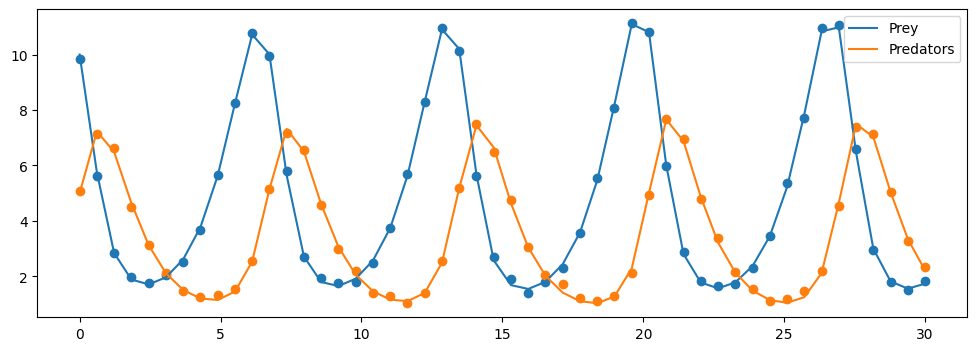

In [7]:
# plot the solution.
plt.figure(figsize=(12,4))
plt.plot(sol.t, sol.y[0,:], label = "Prey")
plt.scatter(t, P)
plt.plot(sol.t, sol.y[1,:], label="Predators")
plt.scatter(t, Q)
plt.legend()
plt.show()

### Bayesian UQ-SINDy

Here we recover the governing equations using UQ-SINDy. For more details on the theory of the method, see Hirsh, S. M., Barajas-Solano, D. A., & Kutz, J. N. (2021). *Sparsifying Priors for Bayesian Uncertainty Quantification in Model Discovery* (arXiv:2107.02107). arXiv. http://arxiv.org/abs/2107.02107

The underlying code used to find the posterior distribution of model parameters is `numpyro.infer.MCMC` using the `numpyro.infer.NUTS` kernel. Note that all keyword arguments passed to `pysindy.optimizers.SBR` are sent forward to the [MCMC sampler](https://num.pyro.ai/en/stable/mcmc.html).

In [8]:
# set sampler hyperparameters
sampling_seed = 123

if __name__ == "testing":
    num_warmup = 10
    num_samples = 100
    num_chains = 1
else:
    num_warmup = 500
    num_samples = 2000
    num_chains = 2

In [9]:
import json
import jax.numpy as jnp

with open('posterior_mean.json') as f:
    posterior_mean = json.load(f)
posterior_mean = {key: jnp.array(value) for key, value in posterior_mean.items()}

In [10]:
# initialise the Sparse bayesian Regression optimizer.
optimizer = ps.optimizers.SBR(num_warmup=num_warmup,
                              num_samples=num_samples,
                              mcmc_kwargs={"seed": sampling_seed,
                                           "num_chains": num_chains},
                              init=posterior_mean)

# use the standard polynomial features.
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True)

# initialise SINDy and fit to the data.
sindy = ps.SINDy(optimizer, feature_library, feature_names=['P', 'Q'])
sindy.fit(np.c_[P, Q], t=t)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['P', 'Q'],
      optimizer=SBR(init={'beta': Array([[ 0.0250865 ,  1.00097048,  0.0083079 , -0.00158618, -0.29215407,
        -0.00793834],
       [-0.00919723,  0.0020673 , -0.98975652,  0.00111375,  0.19207215,
         0.00403425]], dtype=float64),
                          'c_sq': Array(6.87060785, dtype=float64, weak_type=True),
                          'lambda': Array([[ 4.93117905, 75.92147827,  1.1405375 ,  0.48787662, 15.33019924,
         0.63359416],
       [ 1.59191656,  0.83043557, 41.87460709,  0.41992784,  5.76756763,
         0.62485886]], dtype=float64),
                          'sigma': Array(0.77132374, dtype=float64, weak_type=True),
                          'tau': Array(0.08707944, dtype=float64, weak_type=True)},
                    mcmc_kwargs={'num_chains': 2, 'seed': 123},
                    num_samples=2000, num_warmup=500))

In [11]:
# set up a new differential equation that uses the Bayesian SINDy predictions.
def surrogate_dydt(t, y):
    _y = y[np.newaxis,:]
    return sindy.predict(x=_y)

# solve using the Bayesian SINDy equations.
surrogate_sol = solve_ivp(surrogate_dydt, t_span=t_span, y0=y0, t_eval=t_eval)

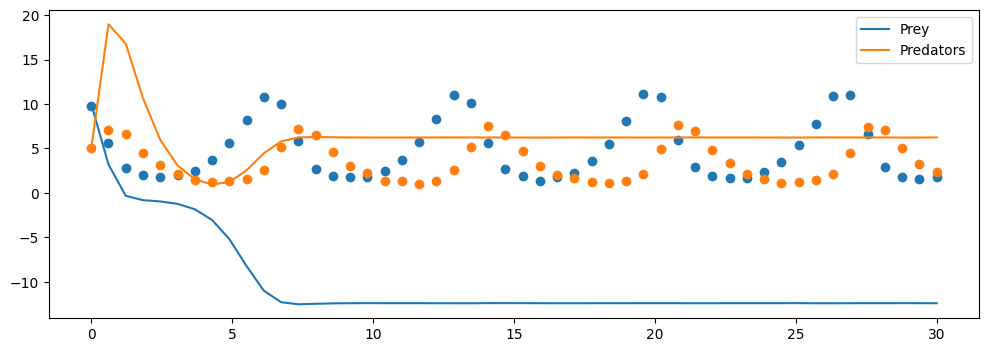

In [12]:
# plot the surrogate solution.
plt.figure(figsize=(12,4))

plt.plot(surrogate_sol.t, surrogate_sol.y[0,:], label = "Prey")
plt.scatter(t, P)

plt.plot(surrogate_sol.t, surrogate_sol.y[1,:], label="Predators")
plt.scatter(t, Q)

plt.legend()
plt.show()

### Get MCMC diagnostics

We can inspect the posterior samples in more detail using `arviz`. Note that this is not included as a dependency of `pysindy` and must be installed separately.

In [13]:
# import arviz.
import arviz as az

In [14]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(sindy.optimizer.mcmc_)

# have a look at the summray.
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.031,0.014,0.008,0.056,0.007,0.005,5.0,13.0,1.34
"beta[0, 1]",1.017,0.023,0.974,1.051,0.016,0.013,2.0,11.0,2.38
"beta[0, 2]",-0.023,0.017,-0.045,0.007,0.011,0.009,3.0,29.0,1.64
"beta[0, 3]",-0.011,0.020,-0.048,0.016,0.012,0.010,3.0,12.0,1.82
"beta[0, 4]",-0.191,0.019,-0.228,-0.161,0.011,0.008,3.0,11.0,1.75
"beta[0, 5]",-0.008,0.002,-0.012,-0.005,0.001,0.001,4.0,28.0,1.42
"beta[1, 0]",0.017,0.042,-0.031,0.085,0.028,0.024,3.0,14.0,2.21
"beta[1, 1]",0.075,0.018,0.050,0.110,0.011,0.009,3.0,11.0,2.22
"beta[1, 2]",-0.960,0.022,-0.995,-0.928,0.015,0.012,3.0,16.0,2.20
"beta[1, 3]",0.161,0.032,0.090,0.202,0.020,0.017,3.0,11.0,1.97


[]

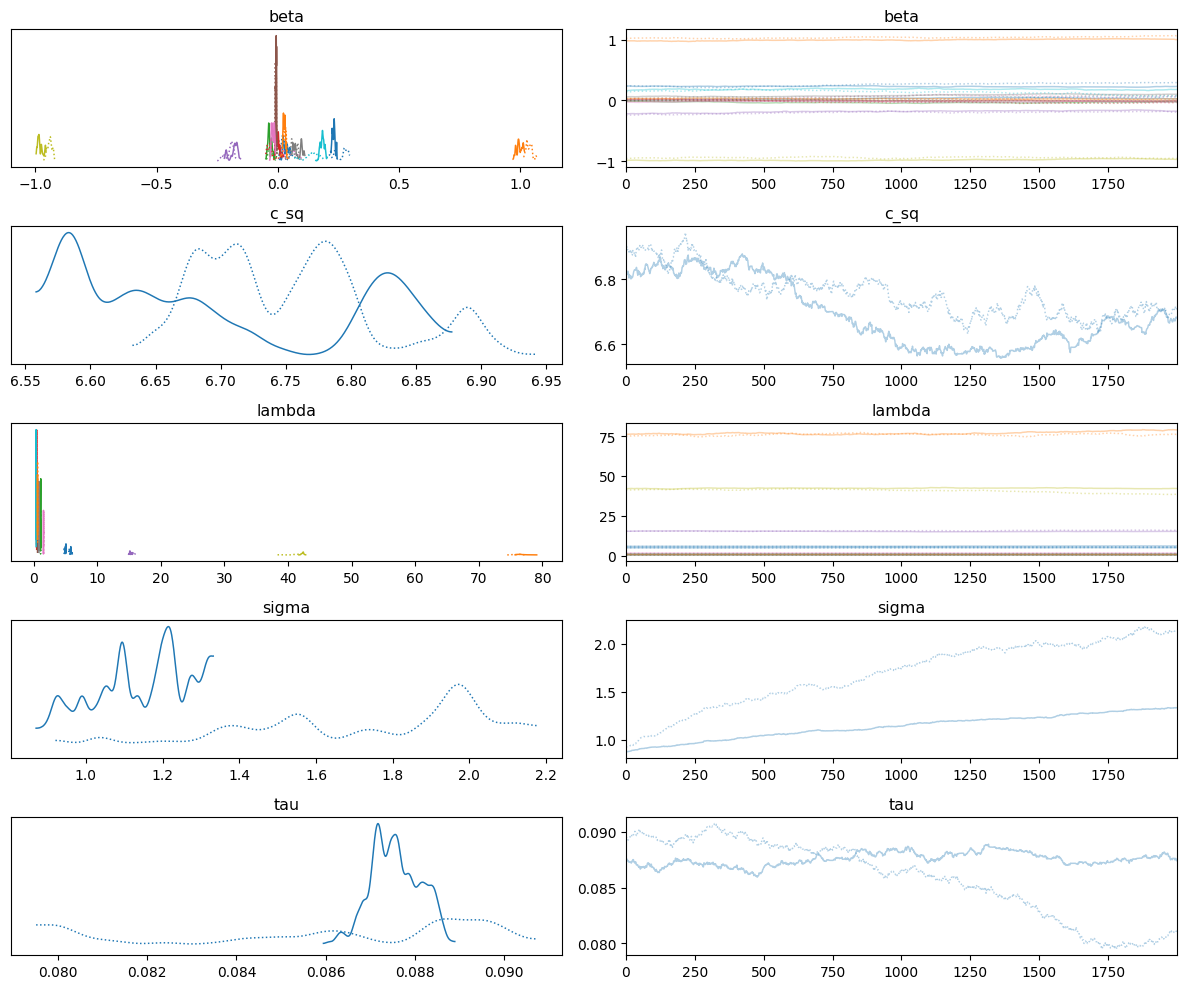

In [15]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()